In [1]:
import numpy as np
import os
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Purify Halo Data

In [3]:
halos_list = os.listdir('/content/drive/MyDrive/data/data/halo/')
halos_list

['13.557halo.dat', '12.903halo.dat', '13.914halo.dat']

In [4]:
size_of_chunk = 1000000

In [ ]:
def process_chunk(chunk_lines):
    points_3d_chunk = []
    for line in chunk_lines:
        parts = line.split()

        if len(parts) < 5:
          continue

        x, y, z = float(parts[0]), float(parts[1]), float(parts[2])
        points_3d_chunk.append([x, y, z])
    return points_3d_chunk

In [ ]:
def load_and_filter_data(file_path, chunk_size, output_csv_path):
    with open(file_path, mode='r') as file:
        with open(output_csv_path + '.csv', mode='a', newline='') as csvfile:
            csv_writer = csv.writer(csvfile)
            chunk_lines = []
            for line in file:
                chunk_lines.append(line)
                if len(chunk_lines) >= chunk_size:
                    processed_data = process_chunk(chunk_lines)
                    csv_writer.writerows(processed_data)
                    chunk_lines = []
            if chunk_lines:
                processed_data = process_chunk(chunk_lines)
                csv_writer.writerows(processed_data)


In [ ]:
for halo in halos_list:
  load_and_filter_data(os.path.join('/content/drive/MyDrive/data/data/halo', halo),
                       size_of_chunk,
                       os.path.join('/content/drive/MyDrive/data/data/processed_halos/', halo[:-4]))
  print(halo)

13.557halo.dat
12.903halo.dat
13.914halo.dat


## Create dataset

In [3]:
!pip install tools21cm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tools21cm: filename=tools21cm-2.1.13-cp310-cp310-linux_x86_64.whl size=53973965 sha256=cbc69c775d3a01b6905d02c18d363fee5c94939b0887e9e34549114e132e2e37
  Stored in directory: /root/.cache/pip/wheels/16/b3/26/7296152f72e131cf61b3c8c2d99d47b82922c465592516664a
Successfully built tools21cm


In [4]:
import os
import tools21cm as t2c
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
halos_dir = '/content/drive/MyDrive/data/data/processed_halos/'
densities_dir = '/content/drive/MyDrive/data/data/n_all/'
xfrac_dir = '/content/drive/MyDrive/data/data/xfrac3d/'
dataset_dir = '/content/drive/MyDrive/data/data/dataset/train/'

In [6]:
processed_halos_list = os.listdir(halos_dir)
print(processed_halos_list)

['13.557halo.csv', '13.914halo.csv', '12.903halo.csv']


In [7]:
density_samples_list = os.listdir(densities_dir)
print(density_samples_list)

['13.557n_all.dat', '12.903n_all.dat', '13.914n_all.dat']


In [8]:
xfrac_samples_list = os.listdir(xfrac_dir)
print(xfrac_samples_list)

['xfrac3d_12.903.bin', 'xfrac3d_13.557.bin', 'xfrac3d_13.914.bin']


In [9]:
global sample_halo_idx
global sample_dense_idx
t2c.set_sim_constants(500)
box_dims = 500/0.7
bins = (300, 300, 300)
halo_threshold = 0.5

In [11]:
def save_halo_sample(halo_file, xfrac, halo_data_path=None):
  global sample_halo_idx
  data = halo_file[[0, 1, 2]].to_numpy()
  print(data.min(), data.max())

  bins = [300, 300, 300]

  hist, edges = np.histogramdd(data, bins=bins)

  dx, dy = box_dims/bins[0], box_dims/bins[1]
  y, x = np.mgrid[slice(dy/2, box_dims, dy),
                  slice(dx/2, box_dims, dx)]

  for idx in range(0, bins[0]):

    #plt.figure(figsize=(3, 3), dpi=100)
    plt.pcolormesh(x, y, hist[idx]/dens.mean() - 1, cmap='hot')
    plt.axis('off')
    plt.savefig(os.path.join(halo_data_path, 'halo_slices', str(sample_halo_idx)+'.png'), bbox_inches='tight', pad_inches=0)
    plt.clf()
    sample_halo_idx = sample_halo_idx + 1

In [12]:
def save_density_sample(dens, xfrac, dense_data_path=None):

  global sample_dense_idx
  dx, dy = box_dims/bins[1], box_dims/bins[2]
  y, x = np.mgrid[slice(dy/2, box_dims, dy),
                  slice(dx/2, box_dims, dx)]

  for idx in range(0, bins[0]):
    #plt.figure(figsize=(3, 3), dpi=100)
    plt.pcolormesh(x, y, dens[idx]/dens.mean()-1, cmap='hot')
    plt.axis('off')
    plt.savefig(os.path.join(dense_data_path, 't21cm_slices', str(sample_dense_idx)+'.png'), bbox_inches='tight', pad_inches=0)
    plt.clf()
    sample_dense_idx = sample_dense_idx + 1


In [13]:
sample_dense_idx = 0
sample_halo_idx = 0
for halo in processed_halos_list:
  red_shift = halo[:-8]
  density_sample = [string for string in density_samples_list if red_shift in string][0]
  xfrac_sample = [string for string in xfrac_samples_list if red_shift in string][0]

  x_file = t2c.XfracFile(os.path.join(xfrac_dir, xfrac_sample))
  d_file = t2c.DensityFile(os.path.join(densities_dir, density_sample))
  halo_file = pd.read_csv(os.path.join(halos_dir, halo), header=None)

  xfrac = x_file.xi
  dens  = d_file.cgs_density

  save_halo_sample(halo_file, xfrac, dataset_dir)
  save_density_sample(dens, xfrac, dataset_dir)
  print(halo)


-0.7729115486 13824.9609375
13.557halo.csv
-1.8522219658 13823.232421875
13.914halo.csv
-1.9116437435 13824.564453125
12.903halo.csv


<Figure size 640x480 with 0 Axes>

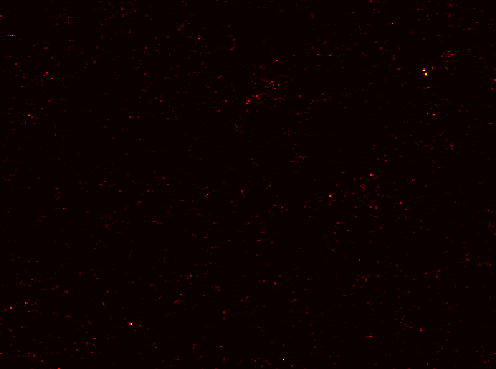

261.75


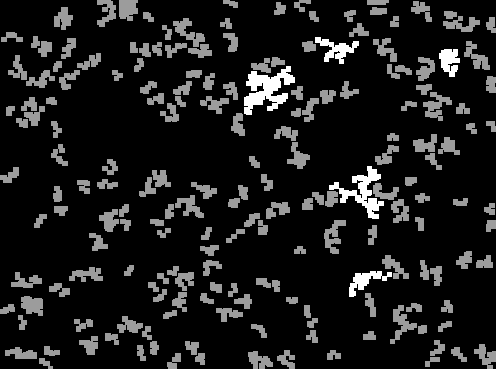

s


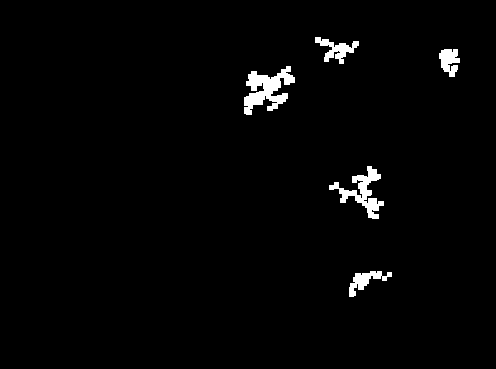

NameError: name 'masses' is not defined

In [14]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

image_path = '/content/drive/MyDrive/data/data/dataset/train/halo_slices/42.png'
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(image)

blurred = cv2.GaussianBlur(gray, (3, 3), 0)

_, binary = cv2.threshold(blurred, blurred.mean(), 255, cv2.THRESH_BINARY)

kernel = np.ones((3,3), np.uint8)  # Adjust the kernel size as needed
dilated = cv2.dilate(binary, kernel, iterations=1)


contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

areas = [cv2.contourArea(contour) for contour in contours]
average_area = sum(areas) / len(areas) if areas else 0
print((max(areas) - min(areas)) / 4)

high_posibility_masses = np.zeros_like(gray)
low_posibility_masses = np.zeros_like(gray)

for contour in contours:
    if  cv2.contourArea(contour) > average_area + (max(areas) - min(areas)) / 4:
        cv2.drawContours(high_posibility_masses, [contour], -1, 255, thickness=cv2.FILLED)
    elif  average_area < cv2.contourArea(contour) < average_area + (max(areas) - min(areas)) / 4:
        cv2.drawContours(low_posibility_masses, [contour], -1, 255, thickness=cv2.FILLED)

cv2_imshow((low_posibility_masses * 100) + high_posibility_masses)
print('s')
cv2_imshow(high_posibility_masses)

cv2.imwrite('/content/drive/MyDrive/data/data/dataset/all_extracted_masses.png', masses)
